<a href="https://colab.research.google.com/github/mwithgod3952/Machine_Learning_Theory_jh/blob/master/Try_new_TIme_seriese_KalmanFilter_basedon_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/strongio/torch-kalman.git#egg=torch_kalman

In [194]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [247]:
import torch

from torch.optim import LBFGS
from copy import deepcopy

from torch_kalman.kalman_filter import KalmanFilter
from torch_kalman.covariance import Covariance
from torch_kalman.process import LocalLevel, LocalTrend, LinearModel, FourierSeason
from torch_kalman.utils.data import TimeSeriesDataset

import glob
import pandas as pd
import numpy as np
import itertools
import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
local_path = '/content/drive/MyDrive/PRSA2017_Data_20130301-20170228 (1)'
filenames = glob.glob(local_path + "/*.csv")

In [197]:
multiple_df_aq = [pd.read_csv(x) for x in filenames]

print("12개 지역별 Air Quality Data 저장구조 : ", np.shape(multiple_df_aq))
print("Columns of each dataframe : ", multiple_df_aq[int(np.random.randint(13, size=1))].columns)

12개 지역별 Air Quality Data 저장구조 :  (12, 35064, 18)
Columns of each dataframe :  Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')


In [198]:
n = 0

for df_aq in multiple_df_aq:
    ds = []
    for i in range(len(df_aq)):
        ds.append(pd.to_datetime(str(df_aq.iloc[i,:]['year']) +  "-" + str(df_aq.iloc[i,:]['month']) + "-" + str(df_aq.iloc[i,:]['day'])).strftime("%Y-%m-%d"))
    multiple_df_aq[n]["ds"] = ds
    multiple_df_aq[n] = multiple_df_aq[n].drop(['No', 'year', 'month',	'day',	'hour'], axis = 1)

    # '열' 재배치
    cols = multiple_df_aq[n].columns.tolist()
    cols.remove('ds')
    multiple_df_aq[n] = multiple_df_aq[n][sum([['ds'], cols], [])]

    n = n + 1 

In [199]:
np.shape(multiple_df_aq)

(12, 35064, 14)

In [200]:
def weekly_average_calculator(i):

    aq_r0 = multiple_df_aq[i].copy()
    aq_r0_daily = aq_r0.groupby('ds').mean()

    num_0 = [0,0,0]

    lst = []
    for i in range(1, math.ceil((len(aq_r0_daily) - 3) / 7)):
        lst.append(list(itertools.repeat(i, 7)))

    num_1 = sum(lst, [])    
    num_2 = list(itertools.repeat(max(num_1) + 1, len(aq_r0_daily) - (len(num_1) + 3)))
    weakly_clustering = sum([num_0 , num_1, num_2], [])    

    aq_r0_daily['weakly_clustering'] = weakly_clustering    

    ds_w = [max(aq_r0_daily[aq_r0_daily['weakly_clustering'] == x].index) for x in set(aq_r0_daily['weakly_clustering'])]

    aq_r0_weakly = aq_r0_daily.groupby(['weakly_clustering']).mean()
    aq_r0_weakly['ds_w'] = ds_w
    
    return aq_r0_weakly

In [201]:
multiple_df_aq_wk = []
i = 0
for ith in range(np.shape(multiple_df_aq)[0]):
    df = weekly_average_calculator(ith)
    df = df.loc[:,['ds_w','SO2','PM10','TEMP','PRES','DEWP']].reset_index().drop('weakly_clustering', 1)
    df['station'] = list(itertools.repeat(multiple_df_aq[i].iloc[:,-1][0], len(df)))
    multiple_df_aq_wk.append(df)
    i = i + 1

In [215]:
df_aq_wk_cc = pd.concat(multiple_df_aq_wk).reset_index()
df_aq_wk_cc['ds_w'] = pd.to_datetime(df_aq_wk_cc['ds_w'])

print('- 컬럼의 구성', df_aq_wk_cc.columns.tolist())
print("- 행의 수: ", df_aq_wk_cc.shape[0], " / ", "열의 수: ", df_aq_wk_cc.shape[1])

- 컬럼의 구성 ['index', 'ds_w', 'SO2', 'PM10', 'TEMP', 'PRES', 'DEWP', 'station']
- 행의 수:  2520  /  열의 수:  8


In [220]:
SPLIT_DT = np.datetime64('2016-02-22') 

col_means = df_aq_wk_cc.loc[df_aq_wk_cc['ds_w'] < SPLIT_DT,:].mean(numeric_only=True)
col_stds  = df_aq_wk_cc.loc[df_aq_wk_cc['ds_w'] < SPLIT_DT,:].std(numeric_only=True)

In [221]:
measures = ['SO2','PM10']
measures_pp = [m + '_log10_scaled' for m in measures]
df_aq_weekly[measures_pp] = np.log10(df_aq_wk_cc[measures] / col_means[measures])

dataset_all = TimeSeriesDataset.from_dataframe(
    dataframe=df_aq_weekly,
    dt_unit='W',
    measure_colnames=measures_pp,
    group_colname='station', 
    time_colname='date'
)

dataset_train, dataset_val = dataset_all.train_val_split(dt=SPLIT_DT)
dataset_train, dataset_val

(TimeSeriesDataset(sizes=[torch.Size([12, 156, 2])], measures=(('SO2_log10_scaled', 'PM10_log10_scaled'),)),
 TimeSeriesDataset(sizes=[torch.Size([12, 54, 2])], measures=(('SO2_log10_scaled', 'PM10_log10_scaled'),)))

In [225]:
processes = []
for measure in measures_pp:
    processes.extend([
        LocalTrend(id=f'{measure}_trend', measure=measure),
        LocalLevel(id=f'{measure}_local_level', decay=(.90,1.00), measure=measure),
        FourierSeason(id=f'{measure}_day_in_year', period=365.25 / 7., dt_unit='W', K=4, measure=measure)
    ])

#
predict_variance = torch.nn.Embedding(
                num_embeddings=len(dataset_all.group_names), embedding_dim=len(measures_pp), padding_idx=0
            )
group_names_to_group_ids = {g : i for i,g in enumerate(dataset_all.group_names)}

kf_first = KalmanFilter(
    measures=measures_pp, 
    processes=processes,
    measure_covariance=Covariance.for_measures(measures_pp, var_predict={'group_ids' : predict_variance})
)

In [226]:
kf_first.opt = LBFGS(kf_first.parameters(), max_iter=10, line_search_fn='strong_wolfe')

def closure():
    kf_first.opt.zero_grad()
    pred = kf_first(
        dataset_train.tensors[0], 
        start_datetimes=dataset_train.start_datetimes, 
        group_ids=[group_names_to_group_ids[g] for g in dataset_train.group_names]
    )
    loss = -pred.log_prob(dataset_train.tensors[0]).mean()
    loss.backward()
    return loss

for epoch in range(12):
    train_loss = kf_first.opt.step(closure).item()
    with torch.no_grad():
        pred = kf_first(
            dataset_val.tensors[0], 
            start_datetimes=dataset_val.start_datetimes,
            group_ids=[group_names_to_group_ids[g] for g in dataset_val.group_names]
        )
        val_loss = -pred.log_prob(dataset_val.tensors[0]).mean().item()
    print(f"EPOCH {epoch}, TRAIN LOSS {train_loss}, VAL LOSS {val_loss}")

EPOCH 0, TRAIN LOSS 2.237034559249878, VAL LOSS -0.6085031032562256
EPOCH 1, TRAIN LOSS -0.6529543995857239, VAL LOSS -0.6077017784118652
EPOCH 2, TRAIN LOSS -0.8010614514350891, VAL LOSS -0.5121809244155884
EPOCH 3, TRAIN LOSS -0.8540120124816895, VAL LOSS -0.501120924949646
EPOCH 4, TRAIN LOSS -0.8751735687255859, VAL LOSS -0.5696712732315063
EPOCH 5, TRAIN LOSS -0.8891637921333313, VAL LOSS -0.6622099280357361
EPOCH 6, TRAIN LOSS -0.8985608816146851, VAL LOSS -0.7236185669898987
EPOCH 7, TRAIN LOSS -0.9104718565940857, VAL LOSS -0.762134313583374
EPOCH 8, TRAIN LOSS -0.9181647300720215, VAL LOSS -0.6961696743965149
EPOCH 9, TRAIN LOSS -0.9229992628097534, VAL LOSS -0.728731095790863
EPOCH 10, TRAIN LOSS -0.9287787675857544, VAL LOSS -0.7235577702522278
EPOCH 11, TRAIN LOSS -0.9303094744682312, VAL LOSS -0.6895239353179932


<Figure size 7200x360 with 0 Axes>

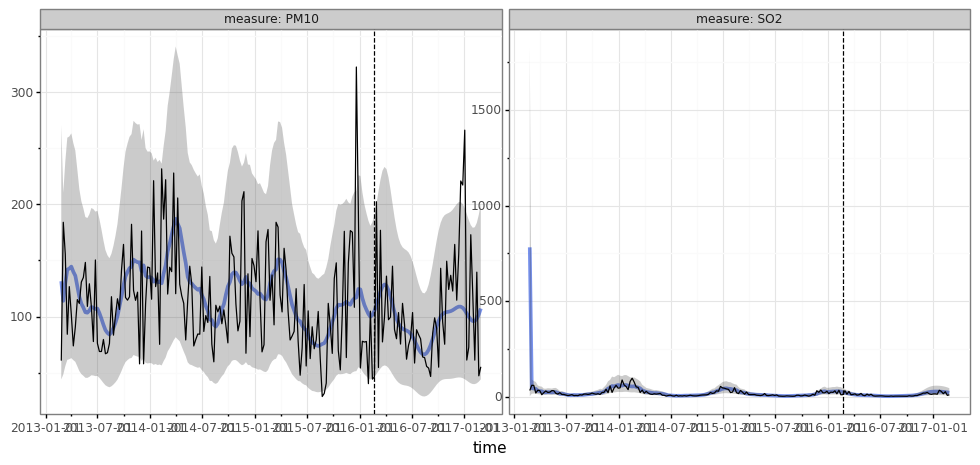

<ggplot: (8793932400573)>


In [252]:
def inverse_transform(df: pd.DataFrame, col_means: pd.Series) -> pd.DataFrame:
    df = df.copy()
    df['measure'] = df['measure'].str.replace('_log10_scaled','')
    std = (df['upper'] - df['lower']) / 1.96
    for col in ['mean','lower','upper','actual']:
        if col == 'mean':
            # bias correction:
            df[col] = df[col] + .5 * std ** 2
        df[col] = 10 ** df[col] # inverse log10
        df[col] *= df['measure'].map(col_means.to_dict()) # inverse scaling
    return df

with torch.no_grad():
    pred = kf_first(
        dataset_train.tensors[0], 
        start_datetimes=dataset_train.start_datetimes,
        group_ids=[group_names_to_group_ids[g] for g in dataset_train.group_names],
        out_timesteps=dataset_all.tensors[0].shape[1]
    )

df_pred = inverse_transform(pred.to_dataframe(dataset_all), col_means)

print(pred.plot(df_pred.query("group=='Wanshouxigong'"), split_dt=SPLIT_DT))